# Query for Spectraction Results in OGA

 work with Weakly_2022_39
- use jupyter kernel LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2022/10/31
- update : 2022/11/01


In [1]:
! eups list -s | grep LOCAL

atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2022_39/atmospec 	setup
drp_pipe              LOCAL:/home/d/dagoret/repos/repos_w_2022_39/drp_pipe 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/eups 	setup
summit_utils          LOCAL:/home/d/dagoret/repos/repos_w_2022_39/summit_utils 	setup


In [2]:
! eups list -s lsst_distrib

   g0b29ad24fb+a10408d0bf 	current w_2022_39 setup


In [3]:
import lsst.daf.butler as dafButler
import lsst.summit.utils.butlerUtils as butlerUtils

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [5]:
import pickle

In [6]:
from astropy.time import Time
import astropy.units as u

## Config

### Butler

In [7]:
#repo =  "/sdf/group/rubin/repo/main"
repo = "/sdf/group/rubin/repo/oga/"
butler = dafButler.Butler(repo)
registry = butler.registry

### Date & Filter & Disperser

In [8]:
# path index for each month
#DATE="20220912"
#DATE="20220913"
DATE="20221207"
filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
#filterdispersername = "FELH0600~holo4_003"

### Spectractor

In [9]:
configmode = "PSF2DFFM"

### The collection

In [10]:
my_collection = "u/dagoret/spectro/noflat/empty~holo4/"+str(DATE)
datasetRefs = registry.queryDatasets(datasetType='spectraction', collections=my_collection, where= "instrument='LATISS'")

In [11]:
# following line not possible in OGA
#butler = butlerUtils.makeDefaultLatissButler(extraCollections=[my_collection])

## Loop on exposures

In [12]:
all_dataId = []     # full data id
all_spec = []       # spectra
all_exposures = []  # exposure number
all_num = []        # sequence numbers



for i, ref in enumerate(datasetRefs):

    print(f"============= ({i}) ============datasetType = spectraction ============================================")
    print("fullId..................:",ref.dataId.full)
    print("visit...................:",ref.dataId["visit"])
    print("band....................:",ref.dataId["band"])
    print("physical filter.........:",ref.dataId["physical_filter"])
    print("run.....................:",ref.run)
    the_exposure = ref.dataId["visit"]
    the_day_obs = ref.dataId["visit"]//100_000
    the_seq_num = ref.dataId["visit"]- the_day_obs*100_000    
    the_dataId = {'day_obs': the_day_obs,'seq_num':the_seq_num,'detector':0}
    print(the_dataId)
    
    # retrieve the spectrum from Butler
    #spec       = butler.get('spectraction',the_dataId)
    spec = butler.get('spectraction', visit=the_exposure, detector=0, collections=my_collection, instrument='LATISS')
    
    # save in collection lists
    all_dataId.append(the_dataId) 
    all_exposures.append(the_exposure)
    all_spec.append(spec)
    all_num.append(the_seq_num)
    if i > 10:
        break

============= (0) ============datasetType = spectraction ============================================
fullId..................: {band: 'white', instrument: 'LATISS', detector: 0, physical_filter: 'empty~holo4_003', visit: 2022120700357}
visit...................: 2022120700357
band....................: white
physical filter.........: empty~holo4_003
run.....................: u/dagoret/spectro/noflat/empty~holo4/20221207/20221209T090018Z
{'day_obs': 20221207, 'seq_num': 357, 'detector': 0}
============= (1) ============datasetType = spectraction ============================================
fullId..................: {band: 'white', instrument: 'LATISS', detector: 0, physical_filter: 'empty~holo4_003', visit: 2022120700361}
visit...................: 2022120700361
band....................: white
physical filter.........: empty~holo4_003
run.....................: u/dagoret/spectro/noflat/empty~holo4/20221207/20221209T094622Z
{'day_obs': 20221207, 'seq_num': 361, 'detector': 0}
============= 

## Plot

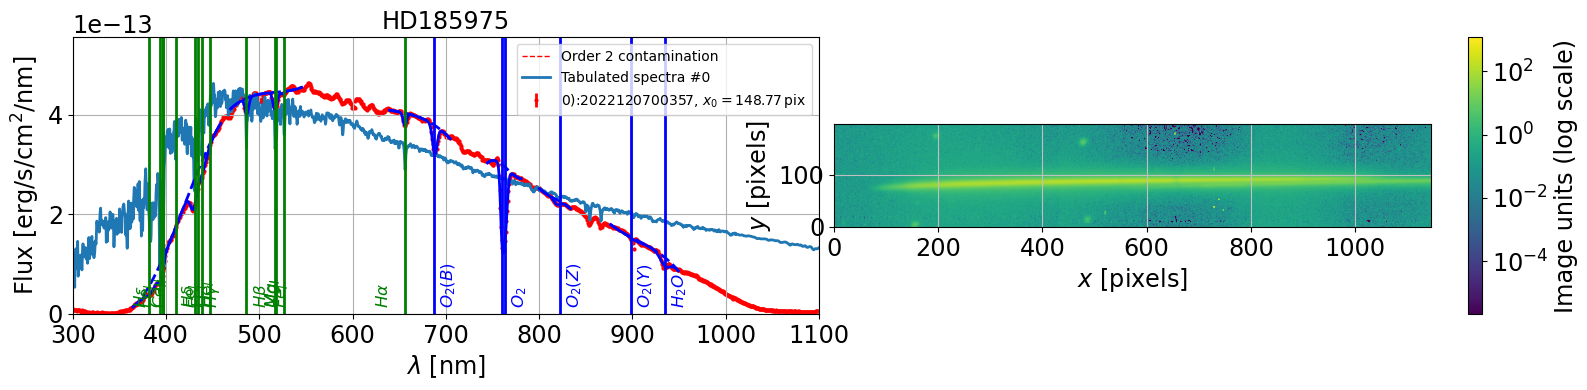

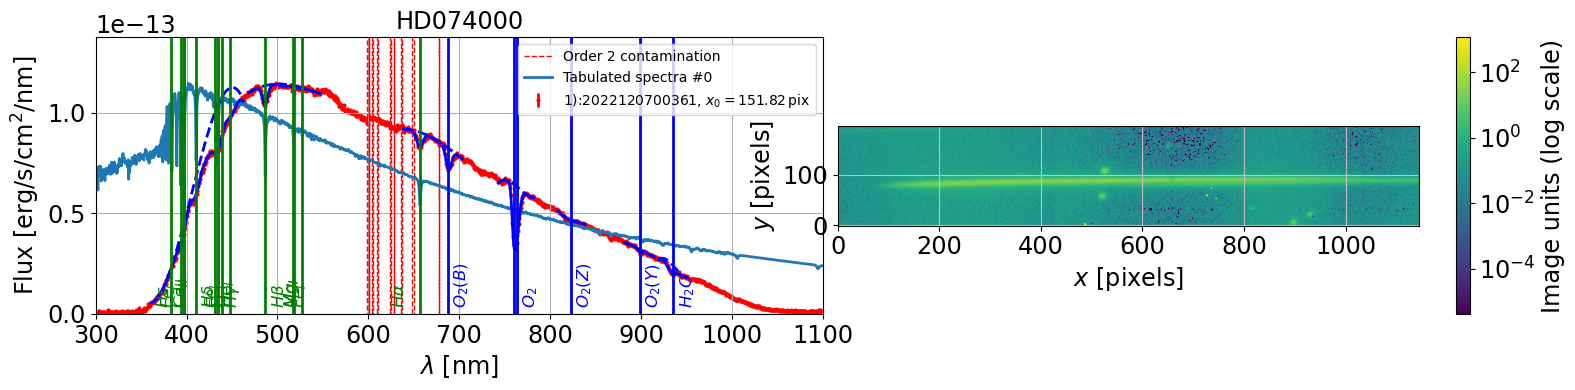

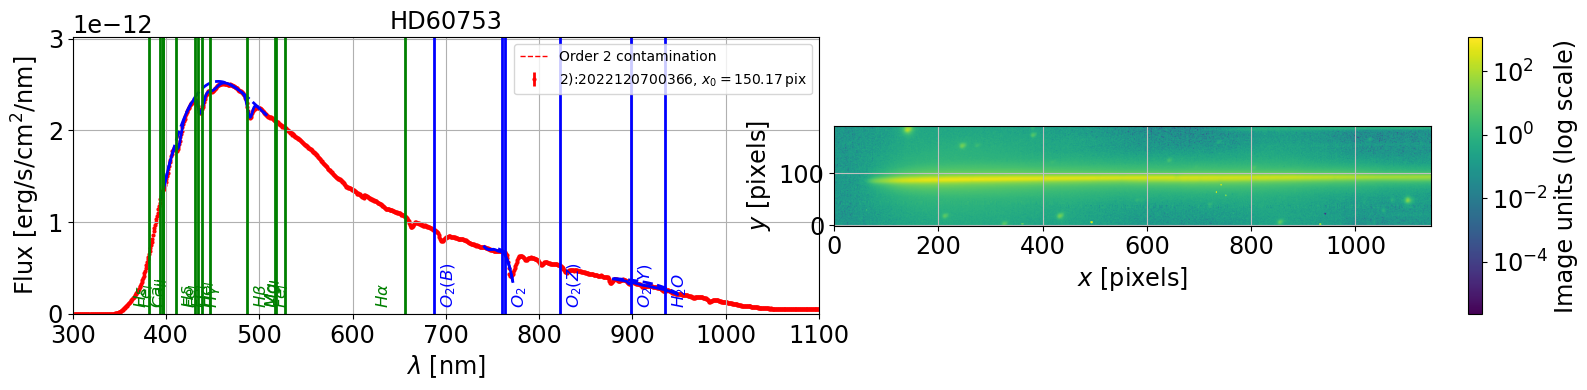

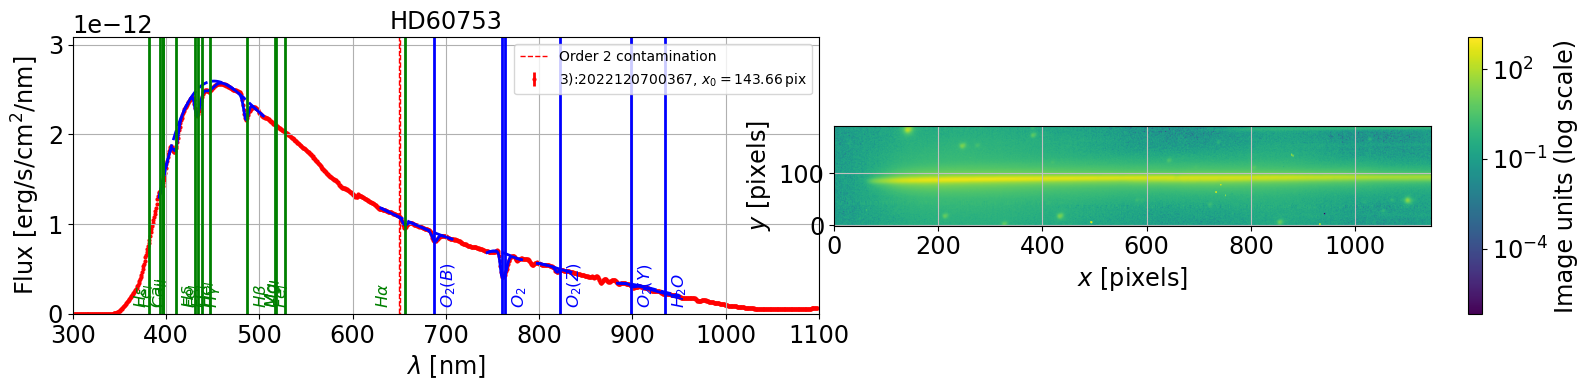

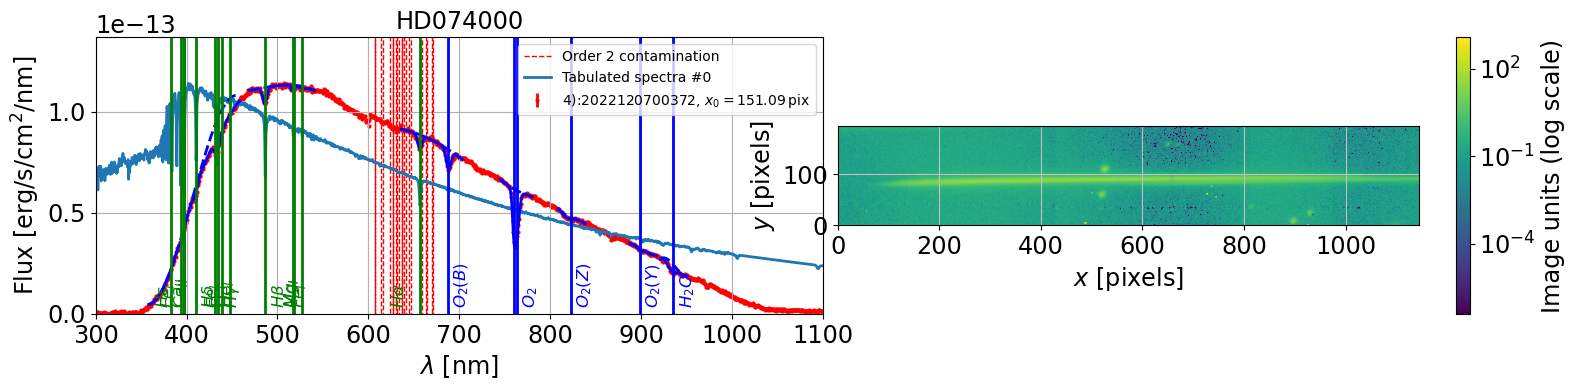

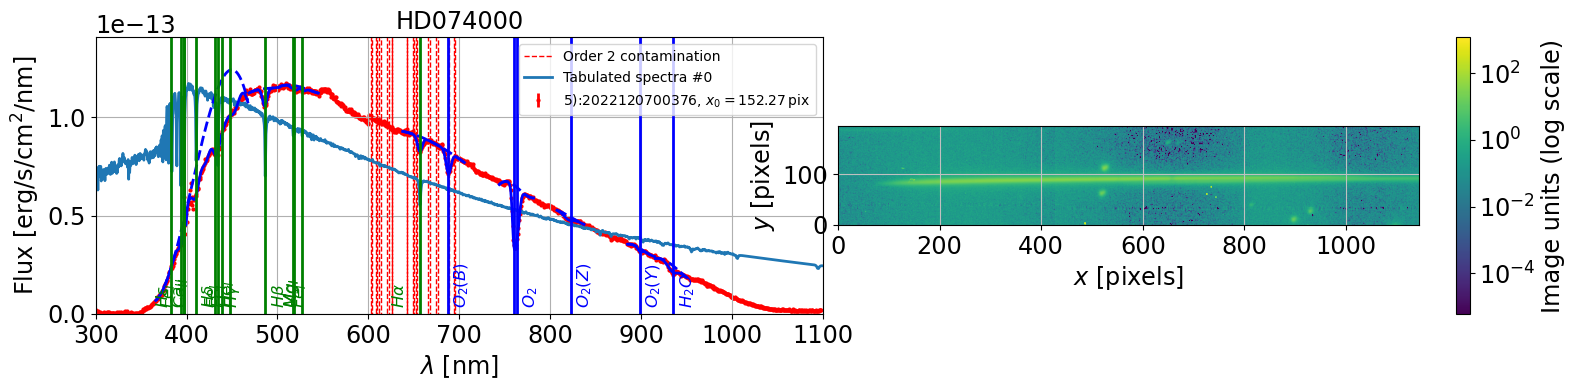

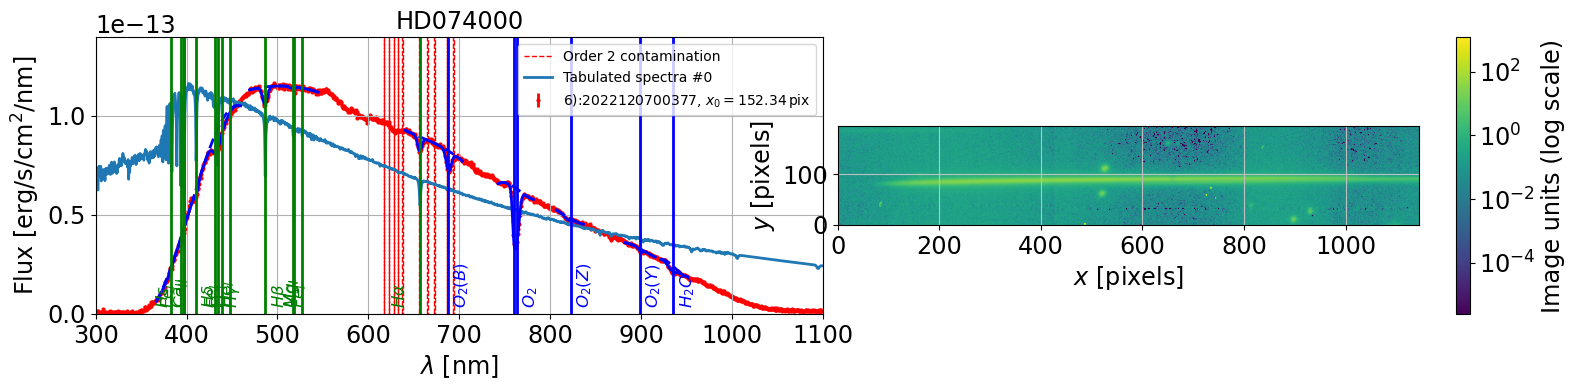

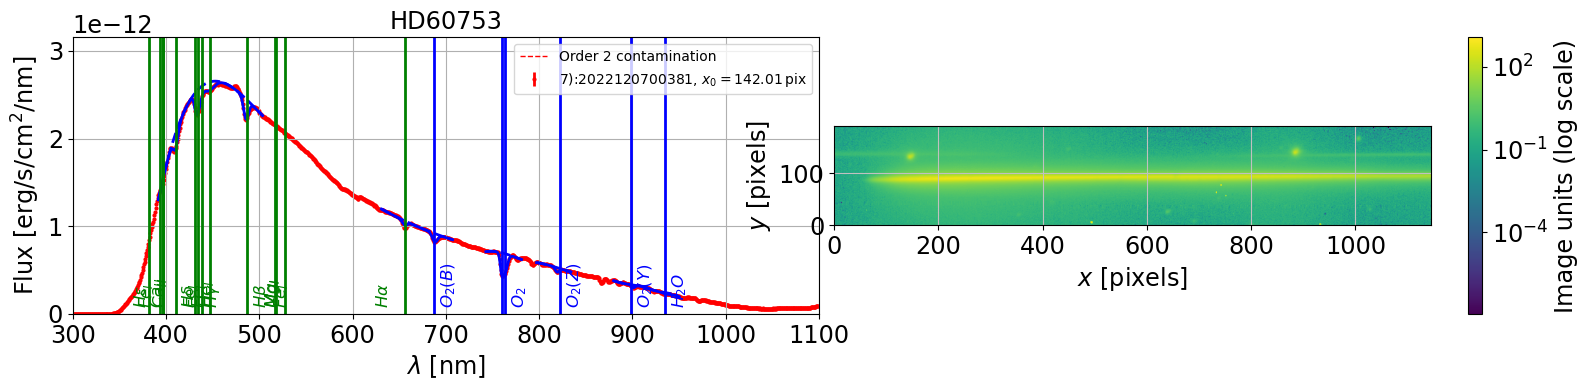

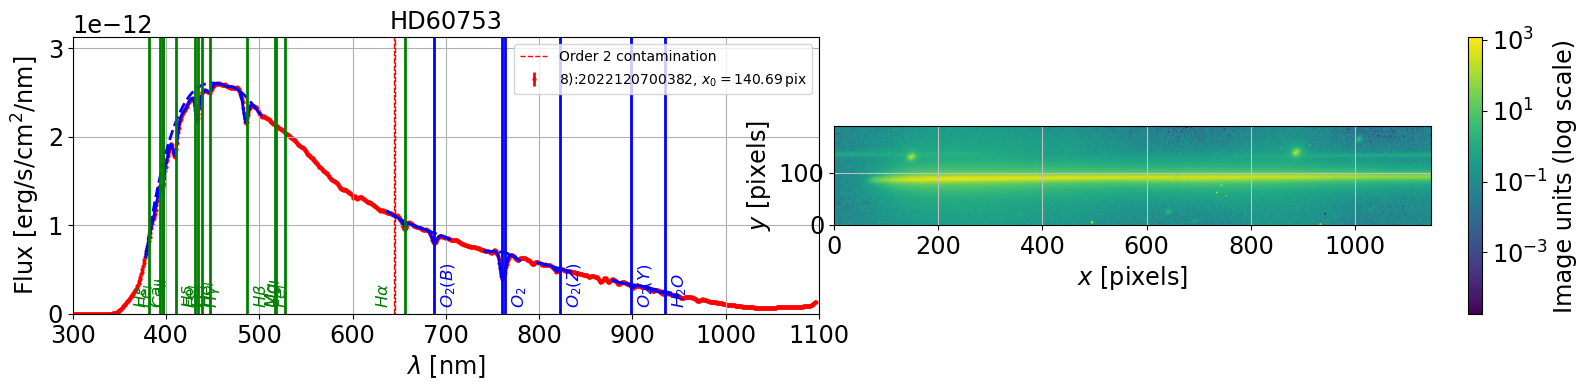

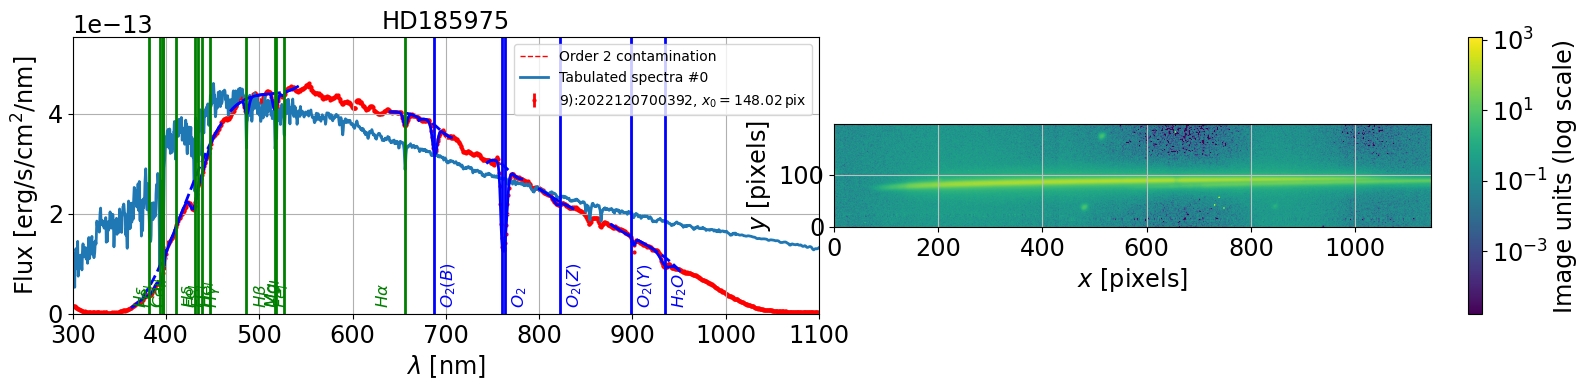

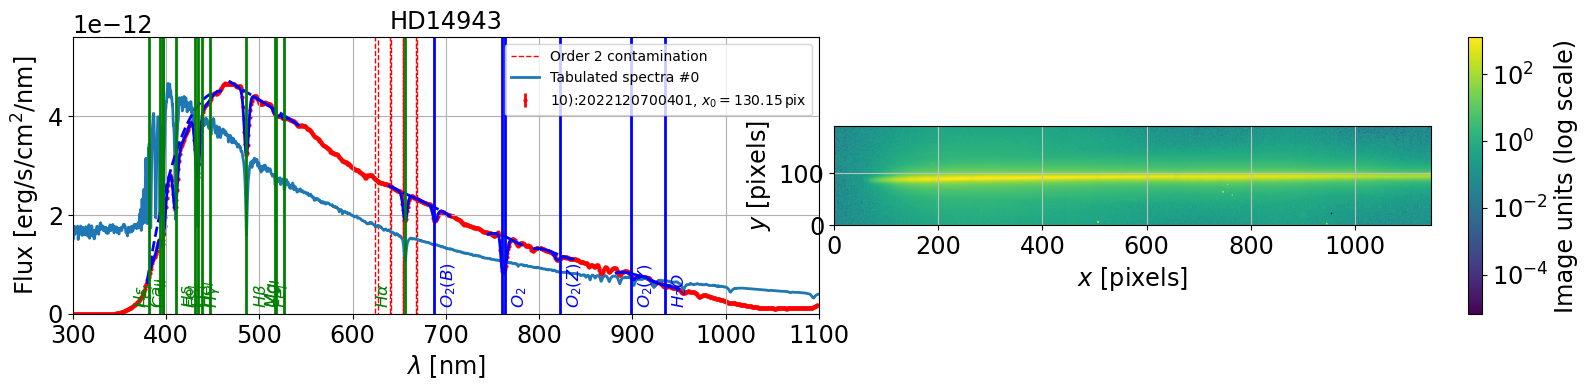

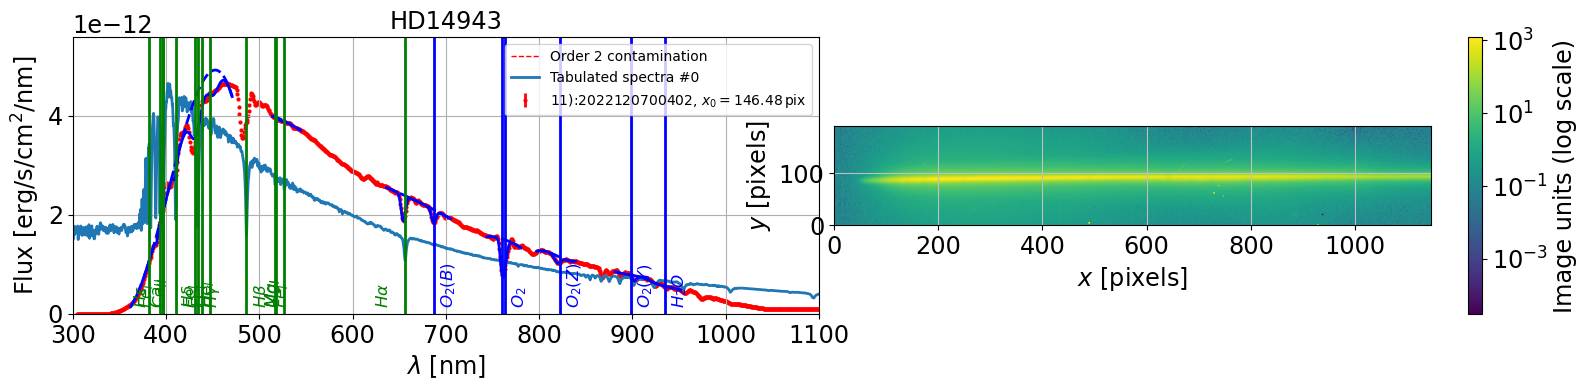

In [13]:
FLAG_ORDER2 = True

infos = []
all_lambdas=[]
all_data=[]
all_data_err=[]

if FLAG_ORDER2:
    all_lambdas_order2=[]
    all_data_order2=[]
    all_data_err_order2=[]


idx=0
for spec in all_spec:
    
    fig=plt.figure(figsize=(16,4))
    
    s=spec.spectrum
    label = str(idx) +"):" + str(all_exposures[idx])
    
    ax1 = fig.add_subplot(1, 2, 1)
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    ax2 = fig.add_subplot(1, 2, 2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    all_lambdas.append(s.lambdas)
    all_data.append(s.data)
    all_data_err.append(s.err)
    
    if FLAG_ORDER2:
        all_lambdas_order2.append(s.lambdas_order2)
        all_data_order2.append(s.data_order2)
        all_data_err_order2.append(s.err_order2)
        
    infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    idx+=1

In [14]:
infos

[[0, 'HD185975', '2022-12-08T04:21:17.963007803Z', 2.06240048739596, 0, 0, 0],
 [1, 'HD074000', '2022-12-08T04:23:57.123991257Z', 1.72874286055651, 0, 0, 0],
 [2, 'HD60753', '2022-12-08T04:26:59.554491889Z', 1.24101590392029, 0, 0, 0],
 [3, 'HD60753', '2022-12-08T04:27:42.478493144Z', 1.23930824123859, 0, 0, 0],
 [4, 'HD074000', '2022-12-08T04:30:42.347990867Z', 1.66941292386214, 0, 0, 0],
 [5, 'HD074000', '2022-12-08T04:43:27.731492362Z', 1.57040524484706, 0, 0, 0],
 [6, 'HD074000', '2022-12-08T04:44:10.592496619Z', 1.56532193379229, 0, 0, 0],
 [7, 'HD60753', '2022-12-08T04:46:30.928001068Z', 1.19811866538924, 0, 0, 0],
 [8, 'HD60753', '2022-12-08T04:47:13.757500996Z', 1.19668409954431, 0, 0, 0],
 [9, 'HD185975', '2022-12-08T04:52:55.851991152Z', 2.08115009703414, 0, 0, 0],
 [10, 'HD14943', '2022-12-08T04:58:06.807002572Z', 1.2837636596589, 0, 0, 0],
 [11, 'HD14943', '2022-12-08T04:58:49.662491975Z', 1.28572703621878, 0, 0, 0]]

In [15]:
all_lambdas

[array([ 299.23891131,  299.94878248,  300.65864277, ..., 1097.29859251,
        1097.97991165, 1098.66119264]),
 array([ 299.05421997,  299.76405498,  300.47387912, ..., 1097.07813203,
        1097.75942534, 1098.44068051]),
 array([ 301.05022972,  301.77123794,  302.49223487, ..., 1110.58691326,
        1111.27818856, 1111.96942409]),
 array([ 299.16314598,  299.87275562,  300.58235439, ..., 1096.93835003,
        1097.61943837, 1098.30048861]),
 array([ 299.40544744,  300.11527722,  300.82509613, ..., 1097.41549508,
        1098.09676981, 1098.77800639]),
 array([ 299.40389023,  300.11379708,  300.82369306, ..., 1096.81697548,
        1097.49835736, 1098.1797011 ]),
 array([ 299.26550219,  299.9755643 ,  300.68561554, ..., 1097.53353152,
        1098.21502026, 1098.89647082]),
 array([ 300.37411056,  301.08395045,  301.79377942, ..., 1097.69248004,
        1098.37376534, 1099.05501249]),
 array([ 299.04174699,  299.75024051,  300.45872321, ..., 1095.59556074,
        1096.2756516 , 

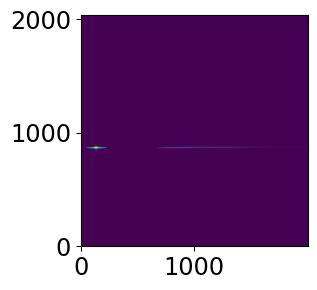

In [16]:
plt.imshow(spec.image.data,origin="lower")

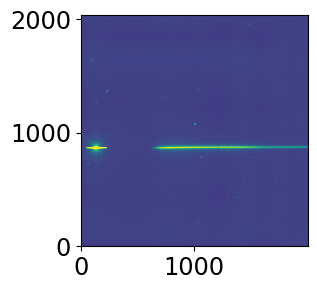

In [17]:
plt.imshow(spec.image.data-spec.image.data.min(),origin="lower",norm=LogNorm(vmin=1,vmax=1000))

# Generate info

In [18]:
df_infos=pd.DataFrame(infos,columns=["idx","object","date_obs","airmass","temperature","pressure","humidity"])

In [19]:
df_infos.set_index('idx',inplace=True)

In [20]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [21]:
all_reftime=np.array(all_reftime)

In [22]:
df_infos["reftime"]=all_reftime

In [23]:
NN = len(df_infos)

In [24]:
df_infos

,object,date_obs,airmass,temperature,pressure,humidity,reftime
idx,,,,,,,
0,HD185975,2022-12-08T04:21:17.963007803Z,2.062400,0,0,0,0.000000
1,HD074000,2022-12-08T04:23:57.123991257Z,1.728743,0,0,0,0.044211
2,HD60753,2022-12-08T04:26:59.554491889Z,1.241016,0,0,0,0.094887
3,HD60753,2022-12-08T04:27:42.478493144Z,1.239308,0,0,0,0.106810
4,HD074000,2022-12-08T04:30:42.347990867Z,1.669413,0,0,0,0.156774
5,HD074000,2022-12-08T04:43:27.731492362Z,1.570405,0,0,0,0.369380
6,HD074000,2022-12-08T04:44:10.592496619Z,1.565322,0,0,0,0.381286
7,HD60753,2022-12-08T04:46:30.928001068Z,1.198119,0,0,0,0.420268
8,HD60753,2022-12-08T04:47:13.757500996Z,1.196684,0,0,0,0.432165


### Save info file

In [25]:
summary_file = f"summaryspectra_{DATE}-{filterdispersername}-{configmode}-oga.csv"
df_infos.to_csv(summary_file)

## Main pickle file

In [26]:
#spec.image.target_pixcoords

In [27]:
header = spec.spectrum.header
header

SIMPLE  =                    T                                                  
TARGET  = 'HD14943 '           / name of the target in the image                
REDSHIFT= '1.6e-05 '           / redshift of the target                         
GRATING = 'holo4_003'          / name of the disperser                          
ROTANGLE=   0.1378608084152397 / [deg] angle of the dispersion axis             
D2CCD   =    177.8419360587513 / [mm] distance between disperser and CCD        
LSHIFT  =                  0.0                                                  
PARANGLE=    75.23590002675346 / parallactic angle in degree                    
TARGETX =    146.4751286362349 / target position on X axis                      
TARGETY =    867.5372060818087 / target position on Y axis                      
THETAFIT=   0.4992181998185721 / [deg] [USED] rotation angle from the Hessian an
THETAINT=  -0.3415047097011261 / [deg] rotation angle interp from disperser scan
LBDA_REF=    658.76901383675

In [28]:


all_rebin=np.zeros(NN)
all_targetx=np.zeros(NN)
all_targety=np.zeros(NN)
all_rotangle=np.zeros(NN)
all_d2ccd=np.zeros(NN)
all_pixshift=np.zeros(NN)
all_chi2_fit=np.zeros(NN)
all_a2_fit=np.zeros(NN)
all_lbda_ref=np.zeros(NN)
all_tagnumber=np.zeros(NN)
all_errors=np.zeros(NN)


for idx in range(NN):
    
    header = all_spec[idx].spectrum.header
    tagnum=str(all_num[idx])
    
    #ROTANGLE=  -0.1367006901184345 / [deg] angle of the dispersion axis             
    #D2CCD   =    179.6778868175837 / [mm] distance between disperser and CCD        
    #TARGETX =    315.9547462941386 / target position on X axis                      
    #TARGETY =    75.06785960446246 / target position on Y axis                      
    #LBDA_REF=    634.9155139280113                                                  
    #PIXSHIFT=  -0.9996981508176748                                                  
    #CHI2_FIT=    1.602115867259752                                                  
    #A2_FIT  =                  1.0                                                  
    #REBIN   =                    2 / original image rebinning factor to get spectrum
    
    try :
        rebin=header["REBIN"]
    except KeyError as e:
        rebin=2
        all_errors[idx]=1
        print(f"KeyError exception for spec {idx}: " + str(e) + f" ! ==> force rebin = {rebin}")
        
        
        
    targetx=header["TARGETX"]*rebin
    targety=header["TARGETY"]*rebin
    rotangle=header["ROTANGLE"]
    d2ccd=header["D2CCD"]
    pixshift=header["PIXSHIFT"]
    
    if header.get("CHI2_FIT") != None:
        chi2_fit=header["CHI2_FIT"]
    else:
        chi2_fit= -1
        
    if header.get("A2_FIT") != None:
        a2_fit=header["A2_FIT"]
    else:
        a2_fit=-1
    
    
    lbda_ref=header["LBDA_REF"]
    
    
    all_rebin[idx]=rebin
    all_targetx[idx]=targetx
    all_targety[idx]=targety
    all_rotangle[idx]=rotangle
    all_d2ccd[idx]=d2ccd
    all_pixshift[idx]=pixshift
    
    
    all_chi2_fit[idx]=chi2_fit
    all_a2_fit[idx]=a2_fit
    all_lbda_ref[idx]=lbda_ref
    all_tagnumber[idx]=tagnum
    


KeyError exception for spec 2: "Keyword 'REBIN' not found." ! ==> force rebin = 2
KeyError exception for spec 3: "Keyword 'REBIN' not found." ! ==> force rebin = 2
KeyError exception for spec 4: "Keyword 'REBIN' not found." ! ==> force rebin = 2
KeyError exception for spec 5: "Keyword 'REBIN' not found." ! ==> force rebin = 2
KeyError exception for spec 6: "Keyword 'REBIN' not found." ! ==> force rebin = 2
KeyError exception for spec 10: "Keyword 'REBIN' not found." ! ==> force rebin = 2
KeyError exception for spec 11: "Keyword 'REBIN' not found." ! ==> force rebin = 2


## Write pickle file

In [29]:
all_out_data = {}

for idx in range(NN):
    if FLAG_ORDER2:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'], 
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'error':all_errors[idx],    
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
               'all_lambdas_order2':all_lambdas_order2[idx],
               'all_fluxes_order2':all_data_order2[idx],
               'all_fluxes_err_order2':all_data_err_order2[idx],
              }
    else:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'],
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'error':all_errors[idx],  
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
            }         
            
    all_out_data[all_exposures[idx]]=thedata


In [30]:
#all_out_data

In [31]:
pkl_outfilename=f'run-auxtel-holo-{DATE}-{filterdispersername}-{configmode}-oga.pickle'

In [32]:
with open(pkl_outfilename, 'wb') as pickle_file:
    pickle.dump(all_out_data,pickle_file)

In [33]:
pkl_infilename=pkl_outfilename

In [34]:
with open(pkl_infilename, 'rb') as pickle_file:
    content = pickle.load(pickle_file)

In [35]:
# Get first value of dictionary
next(iter(content.items()))

(2022120700357,
 {'number': 357.0,
  'object': 'HD185975',
  'dateobs': '2022-12-08T04:21:17.963007803Z',
  'refhour': 0.0,
  'airmass': 2.06240048739596,
  'pressure': 0,
  'temperature': 0,
  'humidity': 0,
  'targetx_pix': 297.53337701176304,
  'targety_pix': 1774.2438817557668,
  'rotangle': 0.13795815075162424,
  'd2ccd': 180.03219015446442,
  'error': 0.0,
  'all_lambdas': array([ 299.23891131,  299.94878248,  300.65864277, ..., 1097.29859251,
         1097.97991165, 1098.66119264]),
  'all_fluxes': array([9.94373869e-15, 8.43893863e-15, 9.79545590e-15, ...,
         5.92208118e-15, 6.24752137e-15, 6.21192360e-15]),
  'all_fluxes_err': array([1.97128687e-15, 1.82153336e-15, 1.62092612e-15, ...,
         3.57898061e-16, 4.68809794e-16, 5.89717342e-16]),
  'all_lambdas_order2': array([ 299.40541545,  300.11528406,  300.82514179, ..., 1097.45837502,
         1098.13968518, 1098.82095718]),
  'all_fluxes_order2': array([44.62503738, 36.85178604, 41.64907272, ...,  0.68203949,
       